## GTZAN Audio classification using Spectograms

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1


In [2]:
data_dir = '/tf/work/Datasets/GTZAN/images_original'\

img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)



Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


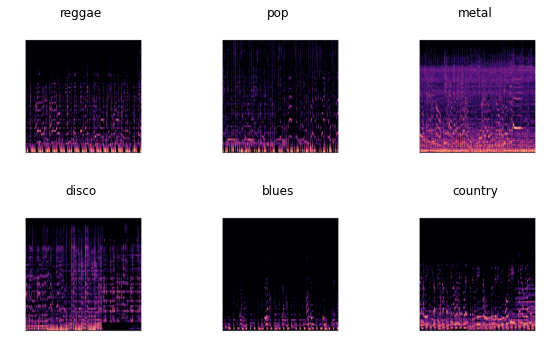

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))

for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
import tensorflow.keras.layers as layers

data_augmentation = keras.Sequential(
  [
#     layers.experimental.preprocessing.RandomFlip(
#         "horizontal", 
#          input_shape=(
#             img_height, 
#             img_width,
#             3
#          )
#     ),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [11]:
num_classes = 10
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [12]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [15]:
epochs=100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
25/25 [==============================] - 7s 167ms/step - loss: 2.4616 - accuracy: 0.1576 - val_loss: 1.7421 - val_accuracy: 0.3869
Epoch 2/100
25/25 [==============================] - 2s 94ms/step - loss: 1.6929 - accuracy: 0.4023 - val_loss: 1.4531 - val_accuracy: 0.5025
Epoch 3/100
25/25 [==============================] - 2s 95ms/step - loss: 1.4506 - accuracy: 0.5252 - val_loss: 1.3623 - val_accuracy: 0.5377
Epoch 4/100
25/25 [==============================] - 2s 96ms/step - loss: 1.3020 - accuracy: 0.5626 - val_loss: 1.3239 - val_accuracy: 0.5427
Epoch 5/100
25/25 [==============================] - 2s 95ms/step - loss: 1.1816 - accuracy: 0.5866 - val_loss: 1.2142 - val_accuracy: 0.5628
Epoch 6/100
25/25 [==============================] - 2s 96ms/step - loss: 1.1806 - accuracy: 0.5957 - val_loss: 1.1966 - val_accuracy: 0.5729
Epoch 7/100
25/25 [==============================] - 2s 96ms/step - loss: 1.1384 - accuracy: 0.6231 - val_loss: 1.2197 - val_accuracy: 0.5176
Epoch

25/25 [==============================] - 2s 96ms/step - loss: 0.4834 - accuracy: 0.8664 - val_loss: 1.2798 - val_accuracy: 0.5528
Epoch 59/100
25/25 [==============================] - 2s 95ms/step - loss: 0.4748 - accuracy: 0.8647 - val_loss: 1.2472 - val_accuracy: 0.5678
Epoch 60/100
25/25 [==============================] - 2s 97ms/step - loss: 0.5028 - accuracy: 0.8486 - val_loss: 1.2196 - val_accuracy: 0.5829
Epoch 61/100
25/25 [==============================] - 2s 96ms/step - loss: 0.4702 - accuracy: 0.8691 - val_loss: 1.1784 - val_accuracy: 0.5829
Epoch 62/100
25/25 [==============================] - 2s 96ms/step - loss: 0.5002 - accuracy: 0.8378 - val_loss: 1.1777 - val_accuracy: 0.5930
Epoch 63/100
25/25 [==============================] - 2s 97ms/step - loss: 0.5113 - accuracy: 0.8388 - val_loss: 1.1904 - val_accuracy: 0.6231
Epoch 64/100
25/25 [==============================] - 2s 96ms/step - loss: 0.4904 - accuracy: 0.8624 - val_loss: 1.1942 - val_accuracy: 0.5930
Epoch 65/100

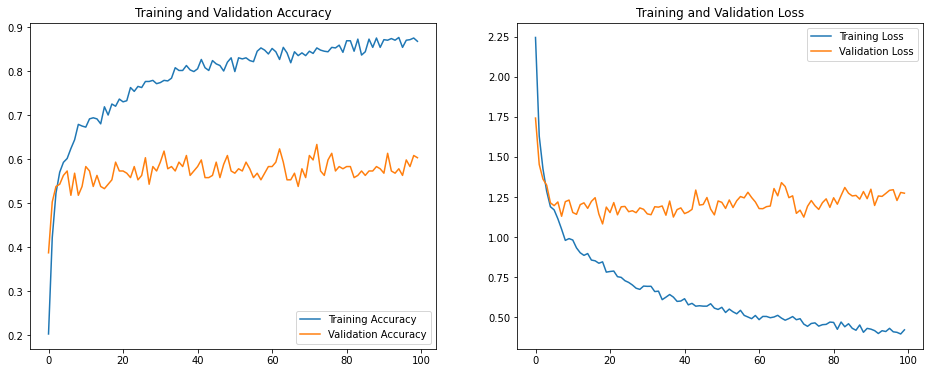

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
import numpy as np
confusion_mat = np.zeros((num_classes, num_classes))

for batch, labels in val_ds:
    preds = np.argmax(model.predict(batch), axis=1)
    for idx in range(len(preds)):
        confusion_mat[labels[idx], preds[idx]] += 1
        
confusion_mat /= confusion_mat.sum(axis=1)
confusion_mat = np.around(confusion_mat, 2)

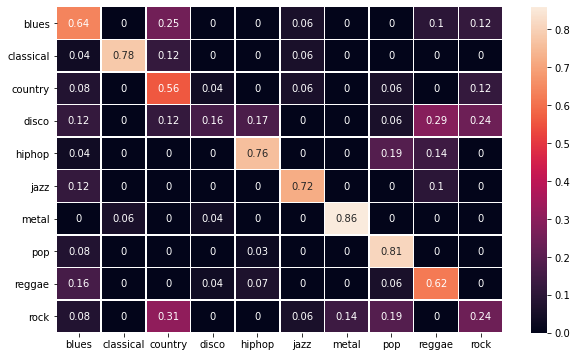

In [18]:
import seaborn as sns

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot()
ax = sns.heatmap(confusion_mat, ax=ax, annot=True, xticklabels=class_names, yticklabels=class_names, linewidth=0.5)